In [1]:
from __future__ import division
import cv2
import time
import sys
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import pickle
import keras

from keras.layers import Input, GlobalAveragePooling2D, TimeDistributed, Dense, Convolution2D, Flatten, CuDNNLSTM, LSTM, Dropout, Reshape
from keras.models import Model
from keras.optimizers import Nadam

Using TensorFlow backend.


### Load data

In [6]:
folder_path = os.path.join(os.getcwd(), "dataset")
print(folder_path)

D:\Desktop\Emotion_classification_Ravdess\dataset


In [19]:
folder_path = "D:\\Desktop\\Ready\\dataset\\"
test_path = "faces_64x64x3_frames_30_skip_0_test_data_80.pickle"
emotions_count = 8

with open(folder_path + test_path, 'rb') as handle:
    test_data = pickle.load(handle)

x_test = []
y_test = []
for item in test_data:
    gray_arr = []
    for image in list(item["images"]):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_arr.append(image)
    
    gray_arr = np.asarray(gray_arr)
    x_test.append(np.expand_dims(gray_arr,axis=3))
    y_test.append(item["emotion"])

# x_test = []
# y_test = []
# for item in test_data:
#     x_test.append(item["images"])
#     y_test.append(item["emotion"])
    
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print(x_test.shape)
print(y_test.shape)

(191, 30, 64, 64)
(191, 8)


### Load model

In [12]:
model_path = "models\\base_emotion_classification_model.hdf5"
model = load_model(model_path, compile=False) 

lr = 0.005
sgd = keras.optimizers.SGD(lr=lr, momentum=0.9, nesterov=True, decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

### Test on all data

In [20]:
result = model.evaluate(x_test, y_test, batch_size=1)
print(result)

ValueError: Error when checking input: expected input_1 to have shape (64, 64, 1) but got array with shape (30, 64, 64)

### Test emotions separately

In [5]:
results_x = []
results_y = []
results = []
emotions_count = 8
for j in range(0, emotions_count):
    emotion_xtest_array = []
    emotion_ytest_array = []
    for i in range(0, len(y_test)):
        if(np.argmax(y_test[i]) == j):
            emotion_xtest_array.append(x_test[i])
            emotion_ytest_array.append(y_test[i])

    emotion_xtest_array = np.asarray(emotion_xtest_array)
    emotion_ytest_array = np.asarray(emotion_ytest_array)
    result = model.evaluate(emotion_xtest_array, emotion_ytest_array, batch_size=1)
    results_x.append(result[0])
    results_y.append(result[1]*100)
    results.append(result)

80/80 [==============================] - 1s 13ms/step


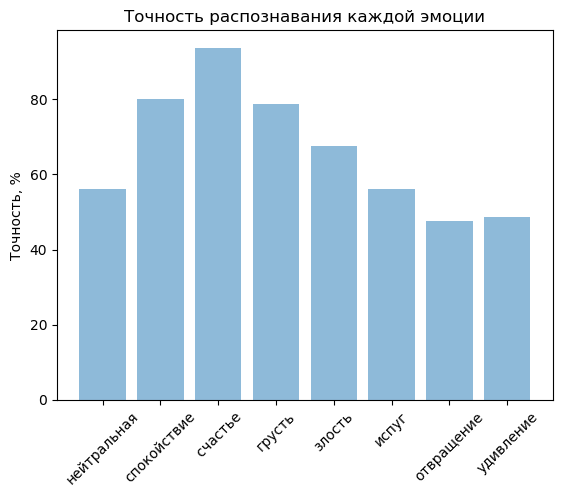

In [11]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

emotions = ["нейтральная", "спокойствие"," счастье", "грусть", "злость", "испуг", "отвращение", "удивление"]
y_pos = np.arange(len(emotions))

plt.bar(y_pos, results_y, align='center', alpha=0.5)
plt.xticks(y_pos, emotions, rotation = "45")
plt.ylabel('Точность, %')
plt.title('Точность распознавания каждой эмоции')

plt.show()

In [7]:
target_names = ['нейтральная', 'спокойствие','счастье', 'грусть', 'злость', 'испуг', 'отвращение', 'удивление']

Y_pred = model.predict(x_test)
y_pred_confusion = np.argmax(Y_pred, axis=1)
y_test_confusion = np.argmax(y_test, axis=1)

In [8]:
from sklearn import svm, datasets
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Нормализованная матрица неточностей'
        else:
            title = 'Матрица неточностей без нормализации'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Нормализованная матрица неточностей")
    else:
        print('Матрица неточностей без нормализации')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Экспертные решения',
           xlabel='Решения классификатора')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Матрица неточностей без нормализации
[[45 31  0  1  1  2  0  0]
 [ 4 64  9  3  0  0  0  0]
 [ 0  5 75  0  0  0  0  0]
 [ 3  1  1 63  1 10  1  0]
 [ 9  5  1  4 54  6  1  0]
 [ 3  0  1 20  6 45  4  1]
 [ 0  0  0  0 40  0 38  2]
 [ 0  0  0  0 40  0  1 39]]
Нормализованная матрица неточностей
[[0.56 0.39 0.   0.01 0.01 0.03 0.   0.  ]
 [0.05 0.8  0.11 0.04 0.   0.   0.   0.  ]
 [0.   0.06 0.94 0.   0.   0.   0.   0.  ]
 [0.04 0.01 0.01 0.79 0.01 0.12 0.01 0.  ]
 [0.11 0.06 0.01 0.05 0.68 0.07 0.01 0.  ]
 [0.04 0.   0.01 0.25 0.07 0.56 0.05 0.01]
 [0.   0.   0.   0.   0.5  0.   0.47 0.03]
 [0.   0.   0.   0.   0.5  0.   0.01 0.49]]


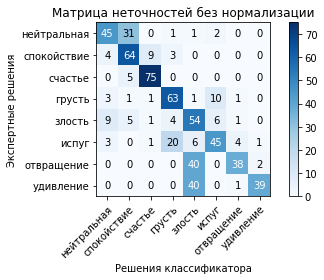

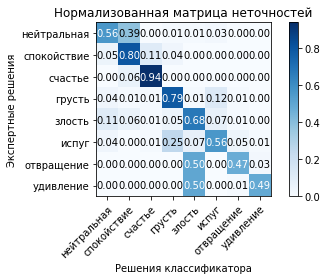

In [9]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_confusion, y_pred_confusion, classes=target_names,
                      title='Матрица неточностей без нормализации')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_confusion, y_pred_confusion, classes=target_names, normalize=True,
                      title='Нормализованная матрица неточностей')

plt.show()

In [10]:
y = classification_report(y_test_confusion, y_pred_confusion, target_names=target_names)

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 30, 64, 64, 1)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 16)            91904     
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 30, 32)            6400      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 32)                8448      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 264       
Total para

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)